In [1]:
import numpy as np
from matplotlib import pyplot as plt
import csv

In [2]:
import mloop.interfaces as mli
import mloop.controllers as mlc
import mloop.visualizations as mlv

In [3]:
np.random.seed(24)

In [4]:
np.set_printoptions(suppress=True)

Este caderno está organizado de modo a facilitar um estudo da efetividade do ajuste dos parâmetros ```L```, ```a``` e ```b``` a curva de carga. Para isso, ele importa a classe ```MOTexperiment``` para a geração de curvas, com ruído aleatório de ordem $10^{-3}$ gerado pelo método ```np.random.random()```. Vale a pena discutir em mais detalhes a estratégia de ajuste escolhida, que tem uma descrição breve nos comentários do código.

* Como discutido na tese de doutarado "Estudo de Colisões Atômicas Ultrafrias: Mecanismos de Perda e Espectroscopia de Fotoassociação", podemos obter duas soluções aproximadas da equação diferencial que rege a população atômica na armadilha, que é 

$$\dot{N} = L -aN - bN²$$

* Para populações iniciais, com $N\ll1$, podemos tomar $\dot{N}=L$ e obter a solução no regime linear

$$N_1(t) = Lt$$

onde fisicamente impomos $N(t)=0$.

* Permitindo que o sistema evolua por tempo o suficiente para que a perda por colisões passe a ser considerável, temos um intervalo no qual $N$ cresce enquanto $N^2$ permanece desprezível, e tomamos $\dot{N} = L - aN$. Neste caso, temos um regime exponencial

$$N_2(t) = \frac{L}{a}\left(1-e^{-at}\right)$$

* Finalmente, a equação completa pode se resolvida exatamente pelo método de funções de Green, e temos

$$N_3(t) = \frac{D}{2b}\tanh\left[\frac{D}{2}t+\text{arctanh}\left(\frac{a}{D}\right)\right]-\frac{a}{2b}$$

* Onde $D=\sqrt{a^2+Lb}$. Notamos que, dada essa solução, $b\neq0$. Essa restrição sobre b surge de $b$ aparecendo isoladamente como denominador, e se inseridade na restrição $D\neq0$, permite que $a\geq0$. $a\approx0$ tem uma significância física que deve ser considerada, e é discutida abaixo.

* Em um primeiro momento, pode parecer natural, já que temos uma solução exata, simplesmente ajustá-la à curva e obter os parâmetros desejados. Entretanto, hão de ser consideradas duas coisa. A primeira, uma questão de eficiência: a procura pelo ajuste ótimo dos parâmetros à curva faz uma procura sobre o espaço de configurações dos parâmetros (aqui, no momento, usamos o algoritmo de Levenberg-Marquadt para ajustes sem limites e o método TRF para ajustes limitados); podemos estimular uma maior precisão na determinação dos parâmetros ótimos do ajuste com uma maior de densidade de pontos de configurações testadas. Uma forma de fazer isso é reduzir a dimensionalidade do problema, outra é impor certos vínculos que reduzam o volume estudado para um espaço de mesma dimensionalidade. É aqui que surge a utilidade das soluções aproximadas. 

* Em seu intervalo de validade (que pode depender da precisão desejada, da densidade de medidas de $N$, da imprecisão das medidas, do perfil da curva...), cada uma delas permite um ajuste para apenas um ou dois parâmetros, simplificando o problema pelo primeiro método: **redução de dimensionalidade**. 

* Ainda podemos explorar a simplificação por **imposição de vínculos**. Estes vínculos devem, é claro, ter motivação física. O primeiro vínculo óbvio é forçar os parâmetros a serem positivos. Um segundo pode ser imposto com base em familiaridade com o aparato experimental: o parâmetro ```a``` caracteriza a perda de átomos da armadilha por colisões destes com átomos livres. Ele depende então do perfil do ambiente dentro da câmara de vácuo onde se faz o aprisionamento, isto é, da qualidade do vácuo. Para um vácuo de alta qualidade, ```a``` deve ser pequeno em relação a outras taxas de variação da população (carregamento e perdas por colisões internas). Neste caso, pode-se justificar a consideração de que, para a precisão conferida pelas medidas, a qualidade dos ajustes e a precisão necessária para a medida dos parâmetros, é razoável tomar a priori que $a=0$. Há uma certa liberdade ainda maior conferida pelos propósitos dos ajustes aqui: tudo que queremos é a construção de uma função custo; medidas razoáveis, ainda que não perfeitas, já podem ser suficientes para a otimização. Estas análises então deixam de ser uma questão de preocupação com a medida de parâmetros, e passam a se caracterizar como uma exploração de funções custo e determinação de suas eficiências para a criação de gases frios de boa qualidade, que é o propósito deste trabalho. 

* A discussão dos métodos de ajuste com base em (1) redução de dimensionalidade e (2) imposição de vínculos sugere uma estratégia geral para o ajuste. Temos uma solução linear, que depende apenas de ```L```; uma solução exponencial, que depende de ```L``` e ```a```; e a solução exata, que depende ```L```, ```a``` e ```b```. Podemos dividir então toda uma curva de carregamento mensurada entre $t=0$ e $t=T$ em três intervalos: $T_1 = \left[0,\texttt{n1trust}\right]$, $T_2 = \left[0,\texttt{n2trust}\right]$ e $T_3 = \left[0,T\right]$, onde ```n1trust``` e ```n2trust``` são parâmetros que passamos ao otimizador. Naturalmente, ajustamos $N_1$ ao intervalo $T_1$, $N_2$ ao intervalo $T_2$ e $N_3$ a $T_3$. Cada ajuste deve ainda utilizar os anteriores para otimizar a si mesmo por uma das duas estratégias mencionadas.

* Dada a simplicidade do regime linear, desde que tenhamos uma quantidade razoável de pontos em $T_1$, podemos fixar ```L``` com seu primeiro ajuste para todos os ajustes subsequentes, reduzindo a dimensionalidade do problema permanentemente. Aqui, como dito, impomos $L>0$.

* Com ```L``` fixo, o ajuste em $T_2$ se refere apenas a $a$, impondo $a>0$. Temos aqui uma consideração retirada da tese: a solução exponencial leva a uma saturação da população na armadilha em $N_S = L/a$. Esta seria a população real sem o segundo canal de perdas dado por $b$. Com $b\neq0$, a população de saturação real deve $N^\prime_S<N_S$. Se consideramos que o ajuste linear de $L$ é satisfatoriamente preciso, então qualquer diferença entre $N^\prime_S$ e $N_S$ se deverá exclusivamente a $a$. Sendo $a^\prime$ o valor de $a$ real, temos então $a^\prime<L/N^\prime_S$. $N^\prime_S$ pode ser determinado tomando $t\to\infty$ na solução exata e e resulta em

$$N^\prime_S = \frac{D-a}{2b}$$

Esse relação nos permitiria construir uma inequalidade do tipo $a^\prime<f(a,b)$ para impôr um vínculo sobre $a$ em um ajuste sobre $T_3$. Alternativamente, podemos considerar que, para um $b\neq0$, a possibilidade mais realista de erro no ajuste individual de $a$ é de um sobreajuste, em que o valor $a$ tenta compensar por perdas extras que, na verdade, se devem a $R$. Supomos que um subajuste não seja uma possibilidade considerável, umas vez que, equivalentemente, essa situação corresponderia ao valor de $a$ compensando por ganhos de $L$, o que não deve ser necessário uma vez que consideramos $L$ como já bem determinado. Desse modo, tomamos o primeiro ajuste individual de $a$ como um limite superior para seu valor de real. 

* Seria possível impôr o vínculo $a<L/N^\prime_S$ a partir de um $N_S^\prime$ medido experimentalmente. Isso depende da observação de um comportamento de saturação na curva, o que, devido a qualidade do vácuo, nem sempre é observado. Não podemos esperar poder impôr esse vínculo, em geral.

* Resta, finalmente o ajuste de $b$. Com $L$ e $a$ fixados, o realizamos sobre $T_3$. Em seguida, optamos por liberar a variação de $a$, utilizando seu valor já ajustado tanto como valor inicial quanto como limite superior. O propósito disso é permitir um balanceamento entre as perdas devidas a $a$ e as perdas devidas a $b$, de forma que talvez também seja justificável tomar o primeiro valor ajustado de $b$ como, além de valor inicial, limite inferior. 

### Geração dos pontos

Para gerar os pontos, vamos usar a classe ```MOT```.

In [5]:
from MOT2 import MOTexperiment

Primeiro carregamos os conjuntos de parâmetros previamente determinados.

In [6]:
param_runs = []
with open('ContasRbCs.csv','r') as csv_file:
    file = csv.reader(csv_file)
    count = 0
    for row in file:
        if count == 0:
            count +=1
        else:
            param_runs.append([float(n) for n in row])

Vamos gerar desde já todas as curvas disponíveis. Mais tarde, descreveremos primeiro a análise sobre uma delas, e então a executaremos sobre uma coleção de curvas de modo a ter um resultado confiável.

In [7]:
curves = []

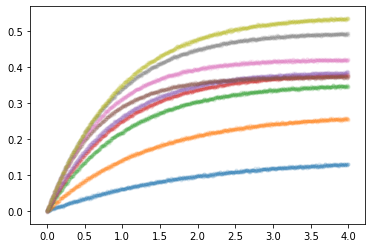

In [8]:
for i in range(9):
    MOTi = MOTexperiment(*param_runs[i])
    MOTi.load_MOT(0.005,4)
    MOTi.measure_loading()
    loading_curve = MOTi.return_loading_curve()
    loading_curve[:,1] = loading_curve[:,1].round(decimals=6)
    curves.append(loading_curve)
    #plt.show()
    #descomentar a linha acima para que cada curva seja
    #exibida individualmente

O tempo de carga é escolhido de modo a imitar o perfil disponível com dados reais, embora naquele caso o  tempo tenha sido de 25 segundos.

### Análise de uma curva

Vamos trabalhar com a curva em ```curves[0]```. Utilizamos a classe ```MOTinterface```, que, contém a rotina de ajuste dos parâmetros da curva.

In [9]:
from MOT import MOTinterface

Uma instância da interface requer apenas um argumento, ```simultaneous_fitting```, que determina se ```g``` e ```L``` serão ajustados simultaneamente após seus ajustes individuais. Seu valor padrão é ```True```.

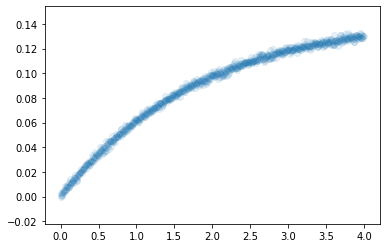

In [10]:
plt.scatter(curves[0][:,0],curves[0][:,1],alpha=0.1)

In [11]:
curves[0][:10]

array([[ 0.      ,  0.003218],
       [ 0.005   ,  0.0015  ],
       [ 0.01    , -0.00023 ],
       [ 0.015   ,  0.002766],
       [ 0.02    ,  0.000196],
       [ 0.025   ,  0.001329],
       [ 0.03    ,  0.004268],
       [ 0.035   ,  0.002858],
       [ 0.04    ,  0.004131],
       [ 0.045   ,  0.003937]])

In [12]:
def main(n1trust,n2trust,simultaneous_fitting = True):
    """Creates an instance of the MOTinterface class, then
    a controller with that interface and a series of 
    configurations (that can be found in the M-LOOP 
    documentation). Lastly, the optimize() method is called
    to start the process."""
    interface = MOTinterface(n1trust,n2trust,simultaneous_fitting)
    controller = mlc.create_controller(interface,
                                       num_params = 3,
                                       min_boundary = [1,0.1,2],
                                       max_boundary = [2,1,3],
                                       first_params = [1.15,0.4,2.6],
                                       max_num_runs = 1,
                                       cost_has_noise = True,
                                       no_delay = False)
    controller.optimize()
    
    return controller

Escrevemos os dados da curva no arquivo que o programa procura

[[ 0.          0.003218  ]
 [ 0.43912176  0.0015    ]
 [ 0.87824351 -0.00023   ]
 [ 1.31736527  0.002766  ]
 [ 1.75648703  0.000196  ]
 [ 2.19560878  0.001329  ]
 [ 2.63473054  0.004268  ]
 [ 3.0738523   0.002858  ]
 [ 3.51297405  0.004131  ]
 [ 3.95209581  0.003937  ]
 [ 4.39121756  0.004995  ]
 [ 4.83033932  0.005228  ]
 [ 5.26946108  0.008927  ]
 [ 5.70858283  0.007951  ]
 [ 6.14770459  0.005756  ]
 [ 6.58682635  0.005767  ]
 [ 7.0259481   0.008104  ]
 [ 7.46506986  0.007934  ]
 [ 7.90419162  0.009199  ]
 [ 8.34331337  0.008246  ]]


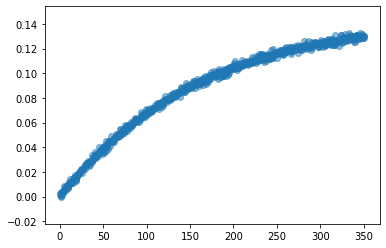

In [13]:
rescaled_data =  curves[0] * [1/np.float64(15.03/1320),1]
print(rescaled_data[:20])
#rescaled_data[:,0] = rescaled_data[:,0].round(decimals=0)
plt.scatter(rescaled_data[:,0],rescaled_data[:,1],alpha=0.5)

In [14]:
filedata=[]
filedata = [str(dat[0])+'\t'+str(dat[1])+'\n' for dat in rescaled_data]

In [15]:
MOT1pd = open('MOT1pd.txt','w')
MOT1pd.write('points\n')
MOT1pd.writelines(filedata)
MOT1pd.close()

Agora chamamos o ajuste

In [16]:
n1s = [0.1*n for n in range(1,11)]
n2s = [(1+0.1*n) for n in range(1,11)]

INFO     Optimization started.
INFO     Run:1 (training)
INFO     params [1.15 0.4  2.6 ]
0.046721951249720235 1.0 1.0
0.046721951249720235 1.6259242961741025e-09 1.0
0.046721951249720235 1.6259242961741025e-09 1.6731751478716028
0.046721951249720235 2.9192893022791166e-14 1.6731725410830363


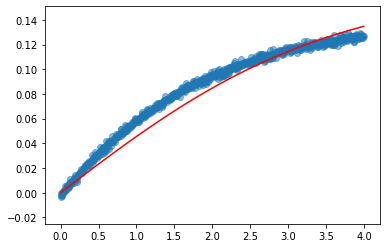

0.046721951249720235 [0.00715901]
2.9192893022791166e-14 0.016929676067778343
1.6731725410830363 0.1883903022206291
INFO     cost 0.046721951249720235 +/- 0.001
INFO     Controller finished. Closing down M-LOOP. Please wait a moment...
INFO     Optimization ended because:-
INFO     Maximum number of runs reached.
INFO     Results:-
INFO     Best parameters found:[1.15 0.4  2.6 ]
INFO     Best cost returned:0.046721951249720235 +/- 0.001
INFO     Best run number:1
INFO     Predicted best parameters:[1.15 0.4  2.6 ]
INFO     Predicted best cost:[0.04672195] +/- [0.00447214]
INFO     M-LOOP Done.
INFO     Optimization started.
INFO     Run:1 (training)
INFO     params [1.15 0.4  2.6 ]
0.05887859078317481 1.0 1.0
0.05887859078317481 0.002327915051982266 1.0
0.05887859078317481 0.002327915051982266 3.270808496747151
0.05887859078317481 9.372142514944176e-12 3.2948910832736784


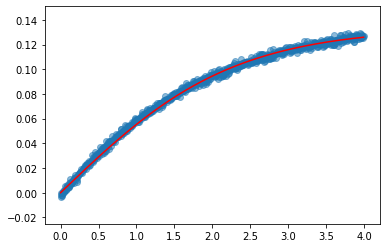

0.05887859078317481 [0.0023523]
9.372142514944176e-12 0.00573103483844516
3.2948910832736784 0.060179433806254096
INFO     cost 0.05887859078317481 +/- 0.001
INFO     Controller finished. Closing down M-LOOP. Please wait a moment...
INFO     Optimization ended because:-
INFO     Maximum number of runs reached.
INFO     Results:-
INFO     Best parameters found:[1.15 0.4  2.6 ]
INFO     Best cost returned:0.05887859078317481 +/- 0.001
INFO     Best run number:1
INFO     Predicted best parameters:[1.15 0.4  2.6 ]
INFO     Predicted best cost:[0.05887859] +/- [0.00447214]
INFO     M-LOOP Done.
INFO     Optimization started.
INFO     Run:1 (training)
INFO     params [1.15 0.4  2.6 ]
0.06080566318974266 1.0 1.0
0.06080566318974266 0.09598329632033685 1.0
0.06080566318974266 0.09598329632033685 2.5438333400237703
0.06080566318974266 0.014339322383853343 3.387934425485832


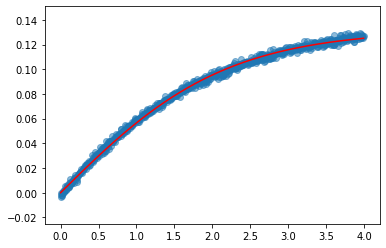

0.06080566318974266 [0.00121489]
0.014339322383853343 0.005186530607599291
3.387934425485832 0.05419871766390433
INFO     cost 0.06080566318974266 +/- 0.001
INFO     Controller finished. Closing down M-LOOP. Please wait a moment...
INFO     Optimization ended because:-
INFO     Maximum number of runs reached.
INFO     Results:-
INFO     Best parameters found:[1.15 0.4  2.6 ]
INFO     Best cost returned:0.06080566318974266 +/- 0.001
INFO     Best run number:1
INFO     Predicted best parameters:[1.15 0.4  2.6 ]
INFO     Predicted best cost:[0.06080566] +/- [0.00447214]
INFO     M-LOOP Done.
INFO     Optimization started.
INFO     Run:1 (training)
INFO     params [1.15 0.4  2.6 ]
0.06275455476939151 1.0 1.0
0.06275455476939151 0.17389726912278308 1.0
0.06275455476939151 0.17389726912278308 1.9813093433250097
0.06275455476939151 0.08349472639172469 2.9160224503069956


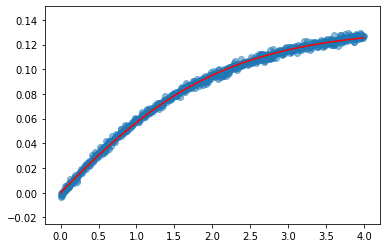

0.06275455476939151 [0.00077345]
0.08349472639172469 0.004850647617146648
2.9160224503069956 0.05066817251330566
INFO     cost 0.06275455476939151 +/- 0.001
INFO     Controller finished. Closing down M-LOOP. Please wait a moment...
INFO     Optimization ended because:-
INFO     Maximum number of runs reached.
INFO     Results:-
INFO     Best parameters found:[1.15 0.4  2.6 ]
INFO     Best cost returned:0.06275455476939151 +/- 0.001
INFO     Best run number:1
INFO     Predicted best parameters:[1.15 0.4  2.6 ]
INFO     Predicted best cost:[0.06275455] +/- [0.00447214]
INFO     M-LOOP Done.
INFO     Optimization started.
INFO     Run:1 (training)
INFO     params [1.15 0.4  2.6 ]
0.06334314760276105 1.0 1.0
0.06334314760276105 0.2069613400409567 1.0
0.06334314760276105 0.2069613400409567 1.7123902223413061
0.06334314760276105 0.1041631716187578 2.7755358424930816


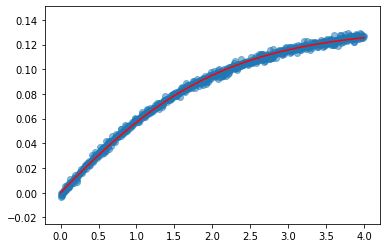

0.06334314760276105 [0.00056469]
0.1041631716187578 0.004763681971932191
2.7755358424930816 0.04975413438942746
INFO     cost 0.06334314760276105 +/- 0.001
INFO     Controller finished. Closing down M-LOOP. Please wait a moment...
INFO     Optimization ended because:-
INFO     Maximum number of runs reached.
INFO     Results:-
INFO     Best parameters found:[1.15 0.4  2.6 ]
INFO     Best cost returned:0.06334314760276105 +/- 0.001
INFO     Best run number:1
INFO     Predicted best parameters:[1.15 0.4  2.6 ]
INFO     Predicted best cost:[0.06334315] +/- [0.00447214]
INFO     M-LOOP Done.
INFO     Optimization started.
INFO     Run:1 (training)
INFO     params [1.15 0.4  2.6 ]
0.06326296766057203 1.0 1.0
0.06326296766057203 0.21797451146338453 1.0
0.06326296766057203 0.21797451146338453 1.588122555488913
0.06326296766057203 0.10135350124479793 2.794618471135137


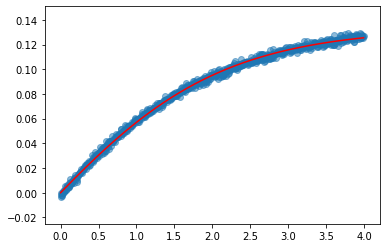

0.06326296766057203 [0.0004501]
0.10135350124479793 0.004775117063541347
2.794618471135137 0.04987432196079146
INFO     cost 0.06326296766057203 +/- 0.001
INFO     Controller finished. Closing down M-LOOP. Please wait a moment...
INFO     Optimization ended because:-
INFO     Maximum number of runs reached.
INFO     Results:-
INFO     Best parameters found:[1.15 0.4  2.6 ]
INFO     Best cost returned:0.06326296766057203 +/- 0.001
INFO     Best run number:1
INFO     Predicted best parameters:[1.15 0.4  2.6 ]
INFO     Predicted best cost:[0.06326297] +/- [0.00447214]
INFO     M-LOOP Done.
INFO     Optimization started.
INFO     Run:1 (training)
INFO     params [1.15 0.4  2.6 ]
0.06277365898908809 1.0 1.0
0.06277365898908809 0.21665862856527907 1.0
0.06277365898908809 0.21665862856527907 1.5402241275223483
0.06277365898908809 0.08416703059539254 2.9114490724757363


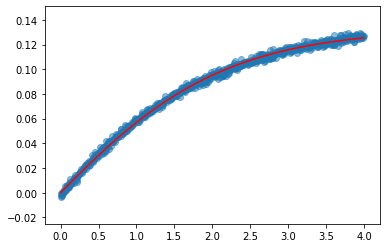

0.06277365898908809 [0.00037119]
0.08416703059539254 0.004847716144260438
2.9114490724757363 0.050637361184268
INFO     cost 0.06277365898908809 +/- 0.001
INFO     Controller finished. Closing down M-LOOP. Please wait a moment...
INFO     Optimization ended because:-
INFO     Maximum number of runs reached.
INFO     Results:-
INFO     Best parameters found:[1.15 0.4  2.6 ]
INFO     Best cost returned:0.06277365898908809 +/- 0.001
INFO     Best run number:1
INFO     Predicted best parameters:[1.15 0.4  2.6 ]
INFO     Predicted best cost:[0.06277366] +/- [0.00447214]
INFO     M-LOOP Done.
INFO     Optimization started.
INFO     Run:1 (training)
INFO     params [1.15 0.4  2.6 ]
0.06233594792827439 1.0 1.0
0.06233594792827439 0.2178133853615179 1.0
0.06233594792827439 0.2178133853615179 1.4729589754056907
0.06233594792827439 0.06873501113818029 3.0165015569290117


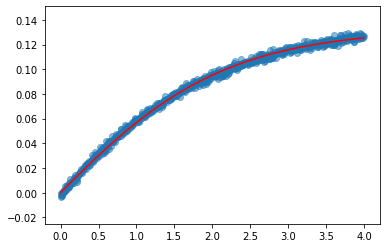

0.06233594792827439 [0.00030229]
0.06873501113818029 0.004916691259148281
3.0165015569290117 0.05136230871165322
INFO     cost 0.06233594792827439 +/- 0.001
INFO     Controller finished. Closing down M-LOOP. Please wait a moment...
INFO     Optimization ended because:-
INFO     Maximum number of runs reached.
INFO     Results:-
INFO     Best parameters found:[1.15 0.4  2.6 ]
INFO     Best cost returned:0.06233594792827439 +/- 0.001
INFO     Best run number:1
INFO     Predicted best parameters:[1.15 0.4  2.6 ]
INFO     Predicted best cost:[0.06233595] +/- [0.00447214]
INFO     M-LOOP Done.
INFO     Optimization started.
INFO     Run:1 (training)
INFO     params [1.15 0.4  2.6 ]
0.06163268187886487 1.0 1.0
0.06163268187886487 0.2143198361975387 1.0
0.06163268187886487 0.2143198361975387 1.4200919010982644
0.06163268187886487 0.04382325790532013 3.186387555103929


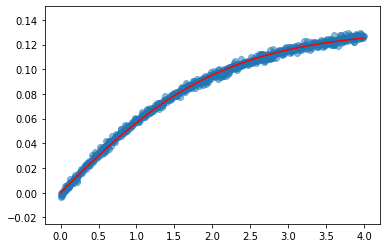

0.06163268187886487 [0.00026265]
0.04382325790532013 0.0050352703886976935
3.186387555103929 0.05260866160156328
INFO     cost 0.06163268187886487 +/- 0.001
INFO     Controller finished. Closing down M-LOOP. Please wait a moment...
INFO     Optimization ended because:-
INFO     Maximum number of runs reached.
INFO     Results:-
INFO     Best parameters found:[1.15 0.4  2.6 ]
INFO     Best cost returned:0.06163268187886487 +/- 0.001
INFO     Best run number:1
INFO     Predicted best parameters:[1.15 0.4  2.6 ]
INFO     Predicted best cost:[0.06163268] +/- [0.00447214]
INFO     M-LOOP Done.
INFO     Optimization started.
INFO     Run:1 (training)
INFO     params [1.15 0.4  2.6 ]
0.06097224468440954 1.0 1.0
0.06097224468440954 0.21231292702405608 1.0
0.06097224468440954 0.21231292702405608 1.3567710916377116
0.06097224468440954 0.020294322096510817 3.3471865603908553


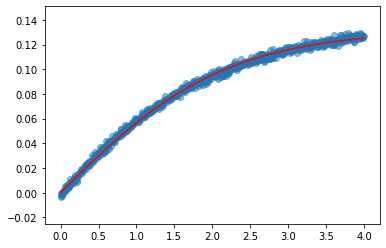

0.06097224468440954 [0.00022995]
0.020294322096510817 0.005155063155934482
3.3471865603908553 0.053867905066414014
INFO     cost 0.06097224468440954 +/- 0.001
INFO     Controller finished. Closing down M-LOOP. Please wait a moment...
INFO     Optimization ended because:-
INFO     Maximum number of runs reached.
INFO     Results:-
INFO     Best parameters found:[1.15 0.4  2.6 ]
INFO     Best cost returned:0.06097224468440954 +/- 0.001
INFO     Best run number:1
INFO     Predicted best parameters:[1.15 0.4  2.6 ]
INFO     Predicted best cost:[0.06097224] +/- [0.00447214]
INFO     M-LOOP Done.


In [17]:
for n1,n2 in zip(n1s,n2s):
    MOT1pd = open('MOT1pd.txt','w')
    MOT1pd.write('points\n')
    MOT1pd.writelines(filedata)
    MOT1pd.close()
    main(n1,n2,True)